#### Ανάλυση dataset

1. Ο κωδικός του dataset μας είναι b03. Αντιστοιχεί στο **Parkinson's telemonitoring** dataset. Αυτό περιλαμβάνει βιοϊατρικες μετρήσεις της φωνής 42 ασθενών με Parkinson's.

2. Υπάρχουν 5875 δείγματα. Κάθε δείγμα περιέχει είκοσι χαρακτηριστικά, συν τον αριθμό του δείγματος. Όλα τα χαρακτηριστικά είναι αριθμητικά. Υπάρχει ένα μη διατεταγμένο χαρακτηριστικό, το φύλλο.

3. Υπάρχουν επικεφάλιδες αλλά όχι αρίθμηση σειρών.

4. Η τέταρτη και η πέμπτη κολώνα περιέχουν τις μεταβλητές στόχους.

5. Τα αρχεία text δε χρειάστηκαν μετατροπή

6. Δεν υπάρχει καμία απουσιάζουσα τιμή (βλ. Out[2]) 

7. Ο διαχωρισμός γίνεται στο In[3].

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn import linear_model
from sklearn import svm

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import explained_variance_score as EVS

from sklearn.kernel_ridge import KernelRidge

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA

from sklearn.multioutput import RegressorChain

import warnings
warnings.filterwarnings("ignore")

In [2]:
data  = pd.read_csv("parkinsons_updrs.data")
# no missing values
data.isnull().any()

subject#         False
age              False
sex              False
test_time        False
motor_UPDRS      False
total_UPDRS      False
Jitter(%)        False
Jitter(Abs)      False
Jitter:RAP       False
Jitter:PPQ5      False
Jitter:DDP       False
Shimmer          False
Shimmer(dB)      False
Shimmer:APQ3     False
Shimmer:APQ5     False
Shimmer:APQ11    False
Shimmer:DDA      False
NHR              False
HNR              False
RPDE             False
DFA              False
PPE              False
dtype: bool

In [3]:
train, test = train_test_split(data, test_size=.2)

y_train = train[["motor_UPDRS", "total_UPDRS"]].copy()
X_train = train.drop(["motor_UPDRS", "total_UPDRS"], axis=1)
y_test  = test[["motor_UPDRS", "total_UPDRS"]].copy()
X_test  = test.drop(["motor_UPDRS", "total_UPDRS"], axis=1)

Σε αυτό το dataset, επειδή υπάρχουν περισσότερα χαρακτηριστικά, κρίθηκε ωφέλιμο να δούμε αν μπορούμε να μειώσουμε την διάσταση. Για τον έλεγχο αυτόν χρησιμοποιήθηκε η μέθοδος PCA. Φυσικά, πριν την εφαρμογή της απαιτείται κανονικοποίηση των δεδομένων, η οποία έγινε μέσω του standard scaler.

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

for n in range(len(X_train.columns)+1):
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(X_train_scaled)
    print('Total Variance Explained with {:>2} features : {}'.format(n, sum(list(pca.explained_variance_ratio_))))

Total Variance Explained with  0 features : 0
Total Variance Explained with  1 features : 0.5663184403355858
Total Variance Explained with  2 features : 0.6524388630446655
Total Variance Explained with  3 features : 0.7270824943359186
Total Variance Explained with  4 features : 0.7860353433014129
Total Variance Explained with  5 features : 0.8368577364163434
Total Variance Explained with  6 features : 0.8850604690230894
Total Variance Explained with  7 features : 0.9221950765574395
Total Variance Explained with  8 features : 0.9500300876275543
Total Variance Explained with  9 features : 0.9646689831784274
Total Variance Explained with 10 features : 0.9744933303600415
Total Variance Explained with 11 features : 0.9830243331887604
Total Variance Explained with 12 features : 0.9908212333996718
Total Variance Explained with 13 features : 0.9957310014871096
Total Variance Explained with 14 features : 0.9976903208284774
Total Variance Explained with 15 features : 0.9986754117303842
Total Var

Τα αποτέλεσματα μας δικαίωσαν. Επιλέξαμε 12 features, τα λίγοτερα ώστε να έχουμε τουλάχιστον 99% εξήγηση της διακύμανσης. Έπειτα, εφαρμόσαμε την αλλαγή σε όλο το dataset.

In [5]:
pca = PCA(n_components=12)
pca_transformer = pca.fit(X_train_scaled)
X_train = pca_transformer.transform(X_train_scaled)
X_test  = pca_transformer.transform(X_test_scaled)

Για το grid search ακολουθήθηκε η ίδια διαδικασία όπως και στο μικρό dataset. Η μόνη διαφορά είναι ότι εδώ εργαζόμαστε με περισσότερους από έναν στόχο. Συνεπώς, δεδομένου του ότι υπάρχει εξάρτηση μεταξύ τους επιλέξαμε τη χρήση Regression chain. Οπότε, απλά περάσαμε κάθε μοντέλο μέσα σε μια αλυσίδας μεγέθους δύο.

In [6]:
models = {"ols"   : linear_model.LinearRegression(),
          "ridge" : linear_model.Ridge(),
          "lasso" : linear_model.Lasso(),
          "elnet" : linear_model.ElasticNet(),
          "poly"  : Pipeline([("polyf", PolynomialFeatures()),("linear", linear_model.LinearRegression())]),
          "ker_r" : KernelRidge(),
          "svm_r" : svm.SVR(),
          "SGD_r" : linear_model.SGDRegressor(),
          "KNN_r" : KNeighborsRegressor(),
          "dtree" : DecisionTreeRegressor(),
          "MLP_r" : MLPRegressor(),
          "HGBR"  : HistGradientBoostingRegressor(),
          "GBR"   : GradientBoostingRegressor(),
          "ETR"   : ExtraTreesRegressor(),
          "RFR"   : RandomForestRegressor()
         }

params = {"ols"   : {},
          
          "ridge" : {"alpha" : [1, .5, 2]},
          
          "lasso" : {"alpha" : [1, .5, 2]},
          
          "elnet" : {"alpha"    : [1, .5, 2],
                     "l1_ratio" : [.5, .25, .75]},
          
          "poly"  : {"polyf__degree" : range(2,5)},
          
          "ker_r" : {"alpha" : [1,  .5,  2],
                     "kernel": ["linear","sigmoid", "rbf", "laplacian"]},
          
          "svm_r" : {"kernel": ["rbf", "sigmoid"]},
          
          "SGD_r" : {"loss"  : ["squared_loss",  "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]},
          
          "KNN_r" : {"n_neighbors" : range(1,8)},
          
          "dtree" : {"criterion"         : ["mse", "friedman_mse", "mae"],
                     "min_samples_split" : range(2,10)},
          
          "MLP_r" : {"activation"         : ["relu", "tanh", "logistic"],
                     "hidden_layer_sizes" : [(100,), (50,), (50,50), (100,100) ,(200, 200)]},
          
          "HGBR"  : {"l2_regularization" : [0, .5, 1],
                     "max_iter"          : [100,200],
                     "min_samples_leaf"  : [20,10]},
          
          "GBR"   : {"n_estimators"          : [100, 200],
                     "learning_rate"         : [.1, .05, .2],
                     "min_impurity_decrease" : [0, .1, .2]
                    },
          
          "ETR"   : {"n_estimators"      : [100, 200],
                     "max_features"      : range(6,1,-1),
                     "min_samples_split" : range(2,8,2)},
          
          "RFR"   : {"n_estimators"      : [100, 200],
                     "max_features"      : range(6,1,-1),
                     "min_samples_split" : range(2,8,2)}
         }

default_params = {k: v.get_params() for k,v in models.items()}

In [7]:
def chain(model): return RegressorChain(base_estimator = model, order = [0, 1])
optimal_params = {}
print("Starting grid search...")
for name, model in models.items(): 
    model_cv = GridSearchCV(estimator  = chain(model),
                            param_grid = {"base_estimator__" + k: v for k,v in params[name].items()},
                            scoring    = "r2", 
                            cv         = 5,
                            n_jobs     = -1,
                            return_train_score = True)
    model_cv.fit(X_train, y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_)
    display(cv_results[[col for col in cv_results.columns if "param_" in col]+["mean_train_score", "mean_test_score"]].style.hide_index())
    optimal_params[name] = cv_results.loc[model_cv.best_index_]["params"]
    default = chain(model).fit(X_train, y_train)
    print("  {:<5} : default score is {:.5f}".format(name, default.score(X_test, y_test)))
    print("        : optimal score is {:.5f}".format(model_cv.score(X_test, y_test)))

Starting grid search...


mean_train_score,mean_test_score
0.243644,0.236898


  ols   : default score is 0.19214
        : optimal score is 0.19214


param_base_estimator__alpha,mean_train_score,mean_test_score
1,0.243644,0.236904
0.500000,0.243644,0.236901
2,0.243644,0.236910


  ridge : default score is 0.19215
        : optimal score is 0.19215


param_base_estimator__alpha,mean_train_score,mean_test_score
1,0.106591,0.103367
0.500000,0.179313,0.174507
2,0.017493,0.014937


  lasso : default score is 0.08822
        : optimal score is 0.14839


param_base_estimator__alpha,param_base_estimator__l1_ratio,mean_train_score,mean_test_score
1,0.500000,0.137468,0.133409
1,0.250000,0.154212,0.149995
1,0.750000,0.121653,0.117716
0.500000,0.500000,0.192559,0.187456
0.500000,0.250000,0.199838,0.195167
0.500000,0.750000,0.183151,0.178369
2,0.500000,0.064988,0.062222
2,0.250000,0.093862,0.090384
2,0.750000,0.045995,0.043311


  elnet : default score is 0.11478
        : optimal score is 0.16335


param_base_estimator__polyf__degree,mean_train_score,mean_test_score
2,0.460646,0.292364
3,0.803618,-2729531.244718
4,0.961204,-35536027765811101411212865306624.000000


  poly  : default score is 0.41599
        : optimal score is 0.41599


param_base_estimator__alpha,param_base_estimator__kernel,mean_train_score,mean_test_score
1,linear,-6.803934,-6.861405
1,sigmoid,-5806.360063,-5522.538865
1,rbf,0.668456,0.589867
1,laplacian,0.783018,0.690764
0.500000,linear,-6.803934,-6.861423
0.500000,sigmoid,-34456.954800,-37460.700036
0.500000,rbf,0.753514,0.661791
0.500000,laplacian,0.853935,0.741636
2,linear,-6.803934,-6.861369
2,sigmoid,-1813.098226,-2204.084896


  ker_r : default score is -7.09914
        : optimal score is 0.77522


param_base_estimator__kernel,mean_train_score,mean_test_score
rbf,0.454263,0.435831
sigmoid,-559.088202,-560.858273


  svm_r : default score is 0.44302
        : optimal score is 0.44302


param_base_estimator__loss,mean_train_score,mean_test_score
squared_loss,0.218131,0.208623
huber,0.037928,0.031901
epsilon_insensitive,0.220441,0.214743
squared_epsilon_insensitive,0.220782,0.218648


  SGD_r : default score is 0.19087
        : optimal score is 0.19181


param_base_estimator__n_neighbors,mean_train_score,mean_test_score
1,1.000000,0.796355
2,0.945601,0.831449
3,0.922490,0.838523
4,0.907349,0.837134
5,0.895851,0.835891
6,0.886622,0.831214
7,0.876958,0.827646


  KNN_r : default score is 0.83977
        : optimal score is 0.84434


param_base_estimator__criterion,param_base_estimator__min_samples_split,mean_train_score,mean_test_score
mse,2,1.000000,0.487270
mse,3,0.996100,0.475234
mse,4,0.989577,0.483505
mse,5,0.980860,0.495592
mse,6,0.973004,0.495451
mse,7,0.963241,0.492687
mse,8,0.956566,0.493935
mse,9,0.949925,0.496290
friedman_mse,2,1.000000,0.478141
friedman_mse,3,0.995999,0.475299


  dtree : default score is 0.53190
        : optimal score is 0.53302


param_base_estimator__activation,param_base_estimator__hidden_layer_sizes,mean_train_score,mean_test_score
relu,"(100,)",0.809463,0.783600
relu,"(50,)",0.725715,0.702568
relu,"(50, 50)",0.942413,0.913561
relu,"(100, 100)",0.973785,0.947530
relu,"(200, 200)",0.982098,0.953323
tanh,"(100,)",0.771548,0.747601
tanh,"(50,)",0.638892,0.619332
tanh,"(50, 50)",0.918590,0.889320
tanh,"(100, 100)",0.950436,0.923772
tanh,"(200, 200)",0.979413,0.956764


  MLP_r : default score is 0.85716
        : optimal score is 0.96838


param_base_estimator__l2_regularization,param_base_estimator__max_iter,param_base_estimator__min_samples_leaf,mean_train_score,mean_test_score
0,100,20,0.916403,0.774401
0,100,10,0.919468,0.771990
0,200,20,0.963651,0.799638
0,200,10,0.966677,0.798967
0.500000,100,20,0.914541,0.774623
0.500000,100,10,0.918541,0.774849
0.500000,200,20,0.962524,0.798706
0.500000,200,10,0.965244,0.799857
1,100,20,0.916924,0.777334
1,100,10,0.918183,0.774340


  HGBR  : default score is 0.77884
        : optimal score is 0.80798


param_base_estimator__learning_rate,param_base_estimator__min_impurity_decrease,param_base_estimator__n_estimators,mean_train_score,mean_test_score
0.100000,0,100,0.633335,0.553027
0.100000,0,200,0.733207,0.626091
0.100000,0.100000,100,0.633329,0.553019
0.100000,0.100000,200,0.733208,0.626122
0.100000,0.200000,100,0.633333,0.552904
0.100000,0.200000,200,0.732630,0.625457
0.050000,0,100,0.543589,0.482173
0.050000,0,200,0.630392,0.548679
0.050000,0.100000,100,0.543590,0.482259
0.050000,0.100000,200,0.630393,0.548581


  GBR   : default score is 0.55362
        : optimal score is 0.69037


param_base_estimator__max_features,param_base_estimator__min_samples_split,param_base_estimator__n_estimators,mean_train_score,mean_test_score
6,2,100,1.000000,0.814104
6,2,200,1.000000,0.816615
6,4,100,0.993620,0.808156
6,4,200,0.993876,0.810555
6,6,100,0.975654,0.794458
6,6,200,0.976540,0.799435
5,2,100,1.000000,0.808422
5,2,200,1.000000,0.809571
5,4,100,0.992117,0.800521
5,4,200,0.992542,0.804368


  ETR   : default score is 0.85871
        : optimal score is 0.83281


param_base_estimator__max_features,param_base_estimator__min_samples_split,param_base_estimator__n_estimators,mean_train_score,mean_test_score
6,2,100,0.965893,0.784091
6,2,200,0.967062,0.786499
6,4,100,0.960352,0.781585
6,4,200,0.961330,0.785675
6,6,100,0.952251,0.779835
6,6,200,0.953782,0.781371
5,2,100,0.966015,0.780328
5,2,200,0.967530,0.785242
5,4,100,0.961147,0.780367
5,4,200,0.961997,0.779399


  RFR   : default score is 0.80137
        : optimal score is 0.81315


Αν αντιπαραθέσουμε τα αποτελέσματα με το μικρό dataset έχουμε να κάνουμε δύο παρατηρήσεις. Η επίδραση των παραμέτρων δεν αλλάζει σε σχέση με πριν αλλά το dataset αυτό είναι πολύ πιο εύκολο να προβλεφθεί. Αυτό φαίνεται απ'όλα τα μη γραμμικά μοντέλα. Ειδικά από τον MLP βλέπουμε ότι απλώς η χρήση δύο κρυφών επιπέδων βελτιώνει τρομερά την απόδοση. Αναμένουμε συνεπώς με ακόμη περισσότερο optimization να έχουμε εξαιρετικά αποτελέσματα.

In [8]:
linear1 = "ols"
linear2 = "ridge"
linear3 = "poly"
gener_1 = "KNN_r"
gener_2 = "MLP_r"
boost_1 = "HGBR"
boost_2 = "ETR"
selected_models = [linear1, linear2, linear3, gener_1, gener_2, boost_1 ,boost_2]
for selected_model in selected_models:
    print(optimal_params[selected_model])

{}
{'base_estimator__alpha': 2}
{'base_estimator__polyf__degree': 2}
{'base_estimator__n_neighbors': 3}
{'base_estimator__activation': 'tanh', 'base_estimator__hidden_layer_sizes': (200, 200)}
{'base_estimator__l2_regularization': 1, 'base_estimator__max_iter': 200, 'base_estimator__min_samples_leaf': 10}
{'base_estimator__max_features': 6, 'base_estimator__min_samples_split': 2, 'base_estimator__n_estimators': 200}


In [9]:
params2 = {"ols"   : {},
          
          "ridge" : {"alpha" : np.arange(1.7, 2.31, .05)},
           
          "poly"  : {"polyf__degree" : range(2,5)},
          
          "KNN_r" : {"n_neighbors": range(1,6)}, 
                      
          "MLP_r" : {"activation"  : ["tanh"],
                     "hidden_layer_sizes": [(200,200), (200,200,200), (300,300)]
                    },
           
          "HGBR"  : {"l2_regularization" : [1],
                     "max_iter"          : range(200,261,10),
                     "min_samples_leaf"  : range(10,21,2)},
          
          "ETR"   : {"n_estimators"      : [200],
                     "max_features"      : [6,8],
                     "min_samples_split" : range(2,7,2)}
         }

In [10]:
for selected_model in selected_models:
    model_cv = GridSearchCV(estimator  = chain(models[selected_model]),
                            param_grid = {"base_estimator__" + k: v for k,v in params2[selected_model].items()},
                            scoring    = "r2", 
                            cv         = 5,
                            n_jobs     = -1,
                            return_train_score = True)
    model_cv.fit(X_train, y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_)
    optimal_params[selected_model] = cv_results.loc[model_cv.best_index_]["params"]

In [11]:
def f(d): return {"base_estimator__" + k: v for k,v in d.items()}
metrics = [R2, MSE, EVS]
metric_names = ["R2", "Mean Squared Error", "Explained Variance", ]
time_dict  = {}
score_dict = {}
for selected_model in selected_models:
    regr = chain(models[selected_model]).set_params(**optimal_params[selected_model])
    fit_start = time.time()
    regr.fit(X_train, y_train)
    fit_end   = time.time()
    time_dict[selected_model] = [fit_end - fit_start]
    predict_start = time.time()
    y_pred = regr.predict(X_test)
    predict_end   = time.time() 
    time_dict[selected_model].append(predict_end - predict_start)
    score_dict[selected_model] = [metric(y_test, y_pred) for metric in metrics]
display(pd.DataFrame.from_dict(time_dict, orient='index', columns=["Fit Time", "Predict Time"]))
score_df = pd.DataFrame.from_dict(score_dict, orient='index', columns=metric_names)
display(score_df)

,Fit Time,Predict Time
ols,0.010000,0.000000
ridge,0.003998,0.001000
poly,0.037000,0.003001
KNN_r,0.023999,0.044000
MLP_r,67.979224,0.037997
HGBR,4.168998,0.020001
ETR,3.617951,0.107969


,R2,Mean Squared Error,Explained Variance
ols,0.192144,71.272602,0.192465
ridge,0.192152,71.272026,0.192473
poly,0.415994,52.243242,0.416680
KNN_r,0.844342,14.235642,0.844451
MLP_r,0.994624,0.489292,0.994841
HGBR,0.815561,17.004677,0.816441
ETR,0.848975,13.746485,0.849258


2. Τα αποτελέσματα που ζητούνται σε μορφή dataframe φαίνονται παραπάνω.
3. Ακολουθεί το bar plot.

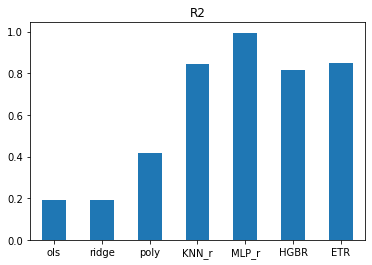

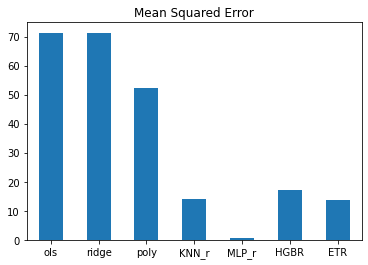

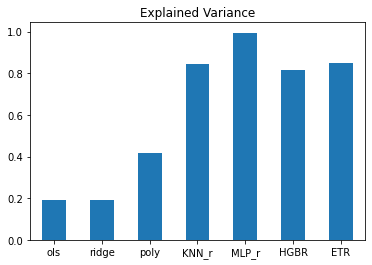

In [12]:
for col in score_df.columns:
    score_df[col].plot.bar(title=col, rot=0)
    plt.show()

In [13]:
score_dict2 = {}
for selected_model in selected_models:
    regr = chain(models[selected_model]).set_params(**f(default_params[selected_model]))
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test) 
    score_dict2[selected_model] = score_dict[selected_model] + [metric(y_test, y_pred) for metric in metrics]
score_df2 = pd.DataFrame.from_dict(score_dict2, orient='index',
                                  columns=["Optimal " + s for s in metric_names] + ["Default " + s for s in metric_names])
score_df2 = score_df2[[score_df2.columns[i] for i in [3,0,4,1,5,2]]]
display(score_df2)

,Default R2,Optimal R2,Default Mean Squared Error,Optimal Mean Squared Error,Default Explained Variance,Optimal Explained Variance
ols,0.192144,0.192144,71.272602,71.272602,0.192465,0.192465
ridge,0.192148,0.192152,71.272347,71.272026,0.192469,0.192473
poly,0.415994,0.415994,52.243242,52.243242,0.416680,0.416680
KNN_r,0.839765,0.844342,14.671642,14.235642,0.839794,0.844451
MLP_r,0.842852,0.994624,14.208865,0.489292,0.843052,0.994841
HGBR,0.778839,0.815561,20.266446,17.004677,0.779810,0.816441
ETR,0.851685,0.848975,13.612819,13.746485,0.852030,0.849258


4. Το ζητούμενο φαίνεται παραπάνω.
5. Η ιστορία εδώ είναι αρκετά μονόπλευρη. Το δίκτυο του MLP θέλει πολύ περισσότερο χρόνο εκπαίδευσης(> 1 λεπτού) αλλά πλησιάζει το 100% στο σκορ. Τα γραμμικά μοντέλα υστερούν εμφανώς ενώ ο KNN και τα μοντέλα boosting κυμαίνονται στα ίδια, ικανοποιητικά, αποτελέσματα.